## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>

### Introduction

A/B tests are very commonly performed by data analysts and data scientists. It is important that we get some practice working with the difficulties of these.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As we work through this notebook, answer the corresponding quiz questions associated with each question.**
The labels for each concept are provided for each question.  This will assure we are on the right track as you work through the project.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.
**Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:


In [2]:
# reading the dataset
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print("Number of rows in the dataset are: {}".format(df.shape[0]))

Number of rows in the dataset are: 294478


c. The number of unique users in the dataset.

In [4]:
print("Number of unique users: {}".format(df.user_id.nunique()))

Number of unique users: 290584


d. The proportion of users converted.

In [5]:
pro_con = df['converted'].mean()*100
print("Proportion of users converted are: {}%".format(round(pro_con,2)))

Proportion of users converted are: 11.97%


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# calculating the misaligned pages
mis_1 = df[(df.group == "control") & (df.landing_page == "new_page")].count()[0]
mis_2 = df[(df.group == "treatment") & (df.landing_page == "old_page")].count()[0]
print("Count of the group 'Control' misaligned with landing page 'New Page' is: %d" %mis_1)
print("Count of the group 'Treatment' misaligned with landing page 'Old Page' is: %d" %mis_2)
print("Number of times the 'New Page' and 'Treatment' don't line up is: %d" %(mis_1 + mis_2))

Count of the group 'Control' misaligned with landing page 'New Page' is: 1928
Count of the group 'Treatment' misaligned with landing page 'Old Page' is: 1965
Number of times the 'New Page' and 'Treatment' don't line up is: 3893


f. Do any of the rows have missing values?

In [7]:
# null value check
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

- No Nulls

In [8]:
# creating a copy of dataframe df
df2 = df.copy()

# dropping rows where pages and group don't line up
df2 = df.drop(df[(df.group == "control") & (df.landing_page == "new_page") | (df.group == "treatment") & (df.landing_page == "old_page")].index)

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

In [10]:
# inspecting df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


a. How many unique **user_id**s are in **df2**?

In [11]:
print("Number of unique users: %d, thus %d entry in the set is duplicate." %(df2.user_id.nunique(), df2.user_id.count() - df2.user_id.nunique()))

Number of unique users: 290584, thus 1 entry in the set is duplicate.


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
print('looking for the duplicate entry')
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

looking for the duplicate entry


1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
print("Information of the duplicate entry.")
df2[df2.duplicated('user_id', keep=False)]

Information of the duplicate entry.


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#dropping the duplicate
df2.drop_duplicates(subset='user_id', inplace = True)

#confirming to check whether the duplicate has been dropped or not
if (df2.shape[0] == df2.user_id.nunique()):
    print( "No Duplicate(s) found!")
else:
    print("Duplicate(s) not removed!")

No Duplicate(s) found!


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
# As the values for converted are one of the two {0, 1} mean can be taken
# to determine the probability
print("P(converted) = %.4f" %df2.converted.mean())

P(converted) = 0.1196


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# As the values for converted are one of the two {0, 1} mean can be taken
# to determine the probability
ctrl_con = df2.groupby('group', as_index=False).describe()['converted']['mean'][0]
print("P(ctrl_con) = %.4f" %ctrl_con)

P(ctrl_con) = 0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
# As the values for converted are one of the two {0, 1} mean can be taken
# to determine the probability
trt_con = df2.groupby('group', as_index=False).describe()['converted']['mean'][1]
print("P(trt_con) = %.4f" %trt_con)

P(trt_con) = 0.1188


d. What is the probability that an individual received the new page?

In [18]:
count_new_p = df2[df2.landing_page == "new_page"].count()[0]
count_users = df2.user_id.nunique()
print("P(new_page_onload) = %.4f" %(count_new_p/count_users))

P(new_page_onload) = 0.5001


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

- Given that computed probabilities for `treatment` and `control` group is approximately the same **11.88%** `(treatment)` $\approx$ **12.04%** `(control)` ~ **12%**; we cannot state whether old or new page is doing good.
- Given that the `old page` is leading the `new page` by a margin of **12.04% - 11.88% = 0.16%**; which cannot be accounted for a change.
- Also, the computed probability that an individual received the new page is = **0.5001**, which means that; there is equally likely possibility of the old page turning up for remaining 50%.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

<a id='sec1'></a>
`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**From the above statement we can define the following:**<br><br>
$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$
$$\alpha = 0.05$$

<a id='q2'></a>
`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

- Given that the assumption from statement [2](#q2), under $H_0$: $p_{new} = p_{old}$.

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# p_new under null 
p_new = df2['converted'].mean()

b. What is the **convert rate** for $p_{old}$ under the null? <br>

In [20]:
# p_new under null 
p_old = df2['converted'].mean()

In [21]:
# p_new under null and p_old under null and p_mean
print("p_new under the null is: %.4f\np_old under the null is: %.4f" %(p_new, p_old))

p_new under the null is: 0.1196
p_old under the null is: 0.1196


c. What is $n_{new}$?

In [22]:
# population or sample size of treatment group
n_new = df2[df2.group == "treatment"].count()[0]
print("The population of user under treatment group: %d" %n_new)

The population of user under treatment group: 145310


d. What is $n_{old}$?

In [23]:
# population or sample size of treatment group
n_old = df2[df2.group == "control"].count()[0]
print("The population of user under treatment group: %d" %n_old)

The population of user under treatment group: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([1, 0], size = n_new, p=[p_new, (1-p_new)]).mean()
new_page_converted

0.11979216846741449

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([1, 0], size = n_old, p=[p_old, (1-p_old)]).mean()
old_page_converted

0.11925051970758704

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
print("The simulated difference is: %.4f" %(new_page_converted - old_page_converted))

The simulated difference is: 0.0005


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [27]:
# applying the null proportion to the total size of each page using the binomial distribution
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

# compute difference from original dataset ab_data.csv
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

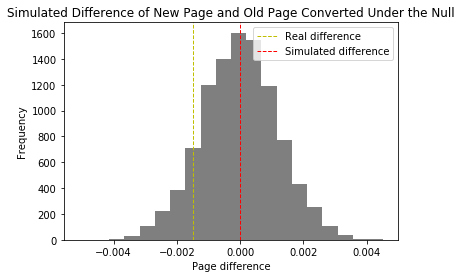

In [28]:
plt.hist(p_diffs, bins = 20, color = 'black', alpha = 0.5)
plt.title('Simulated Difference of New Page and Old Page Converted Under the Null')
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.axvline(x=(act_diff), color='y', linestyle='dashed', linewidth=1, label="Real difference")
plt.axvline(x=(np.array(p_diffs).mean()), color='r', linestyle='dashed', linewidth=1, label="Simulated difference")
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# proportion of p_diffs greater than the actual difference observed in ab_data.csv is computed as:
p_val = (p_diffs > act_diff).mean()

print("Proportion greater than actual difference: %.4f" %p_val)

Proportion greater than actual difference: 0.8915


k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- The calcualted value in part `j` in scientific studies is called the `p-value`.
- The p-value is the conditional probability of the data, given that $H_0$ is true.
- The p-value enables us to take the decision in Hypothesis testing. That is, we compare the p-value to the Type I Threshold $\alpha$.
- Form section [1](#sec1), it is given that $\alpha = 0.05$ and the computed p-value ~ 0.89. From the general thumb rule, greater or larger that value of p, we shouldn't move away from our $H_0$.
- Thus, based on the data _we fail to reject the null hypothesis_ $H_0$. Thus it can be concluded that, the new and the old page, at performance are at par, and  by re-arranging the null as $H_0: p_{new} \leq p_{old}$, it can also be concluded that the new page might be doing even worse than old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "treatment"').count()[0]

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print("The z-score is: %.4f\nThe p-value is: %.4f" %(z_score, p_value))

The z-score is: 1.3109
The p-value is: 0.9051


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [32]:
from scipy.stats import norm

# Tells us how significant our z-score is
print("The significance z-score (p-value) is: %.4f" %norm.cdf(z_score))

# Tells us what our critical value at 95% confidence
print("The critical value at 95%% confidence is: %.4f" %(norm.ppf(1-(0.05/2))))

The significance z-score (p-value) is: 0.9051
The critical value at 95% confidence is: 1.9600


- From the above computation, the `z-score` = **1.3109** and `p-value` = **0.9051**.
- Since the z-score is less than the Critical Value at **95%**, we fail to reject the null hypothesis.
- Yes, the values computed here agree with the findings in part `j` and `k`.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

- From the above statement it can be concluded that, as there are only two possible outcomes **conversion** and **no conversion**, then the best approach is use the **_Logistic Regression_**.
- Thus the null and alternative hypothesis can be defined as:<br><br>
$$H_0: p_{con} = p_{nocon}$$
$$H_1: p_{con} \neq p_{nocon}$$

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df3 = df2.copy()
df3['intercept'] = 1
df3[['ab_page1', 'ab_page2']] = pd.get_dummies(df2['group'])
df3.drop(['ab_page1'], axis = 1, inplace = True)
df3.rename(columns = {'ab_page2' : 'ab_page'}, inplace = True)
df3.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
logm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
result = logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-04-16 21:37 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>

- The p-value for the regression model is **0.1899 $\approx$ 0.190**.
- The reason this computed p-value value differes from the computed p-value in - **Part II**, because we have defined the parameter to be greater than some value in the Alternative Hypothesis. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- The other thing that can be used to analyze the dataset is by using the timestamp column.
- The reason behind using other factor(s), can give you more insight on how much the response variable is dependent on the explanatory variable.
- The disadvantages of adding in extra factors, while checking how best a model can fit can cause misguided results due to the following assumptions:
    - Non-linearity of the response-predictor relationships.
    - Correlation of error terms.
    - Non-constant Variance and Normally Distributed Errors.
    - Outliers/ High leverage points.
    - Multi-collinearity.
- Apart form the above mentioned assumptions, if a dataset is imbalanced, then the accuracy of the model falls down.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.**

Provide the statistical output as well as a written response to answer this question.

In [36]:
# reading the countries.csv and creating dummy variables for countries
df_con = pd.read_csv("countries.csv")
df_con = df_con.merge(df3)
df_con = df_con.join(pd.get_dummies(df_con['country']))
df_con.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [37]:
# lets fit logistic model for the countries, baseline = CA

logm2 = sm.Logit(df_con['converted'], df_con[['intercept', 'US', 'UK']])
result = logm2.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-04-16 21:37 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

- From the above statistics it can be concluded that, there is no significant change to the conversion, as p-values for both countries is greater that the - **Type I Threshold** $\alpha$.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.  

Provide the summary results, and our conclusions based on the results.

In [38]:
# lets fit logistic model for the countries with ab_page, baseline = CA

logm2 = sm.Logit(df_con['converted'], df_con[['intercept', 'ab_page','US', 'UK']])
result = logm2.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-04-16 21:37 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

- From the above statistics it can be concluded that, there is no significant change to the conversion, as p-values for the explanatory variables is greater that the - **Type I Threshold** $\alpha$.

<a id='conclusions'></a>
## Conclusions and Limitations

### Conclusions
- Thus from all the three methods employeed in this report, we can conclude the following:
    - There is a 50% chance that either of the page turns up for a user, irrespective of the group, thus we cannot tell which page has more Click Through Rate.
    - From Hypothesis testing in Part II and Part III, we fail to reject the Null Hypothesis; that is, the old page is doing better than the new page. 
- From the histogram, we can conclude that the new page is doing worse.
- It is also evident that, the dataset was not dependent on countries. As there is a 50% chance for either of the page turning up.

### Limitations
- The analysis is strictly based on the given data.
- Other factors like timestamps and duration of the test that was conducted, are not considered.

### Recommendation
- The e-commerce must do a RCA (Root Cause Analysis) on the IRFT (Input Right First Time) and ORFT (Output Right First Time); were evaluated before the page was put into placed.
- And also perform QC (Quality Check) on multiple iterations of the page, provided that iteration were done.